In [1]:
from htke.load_data import *
from htke.process_ir_data import *
from htke.load_conditions import *
from htke.spka import *
from htke.rpka import *
pd.options.mode.chained_assignment = None  # default='warn' stops the slice error

Go to directory

In [2]:
%pwd
%cd ir_data/GL-06-56-5

C:\Users\Paul Dingwall\Documents\github\htke\ir_data\GL-06-56-5


### Load Raw Data (load_data)

<AxesSubplot:xlabel='Relative Time'>

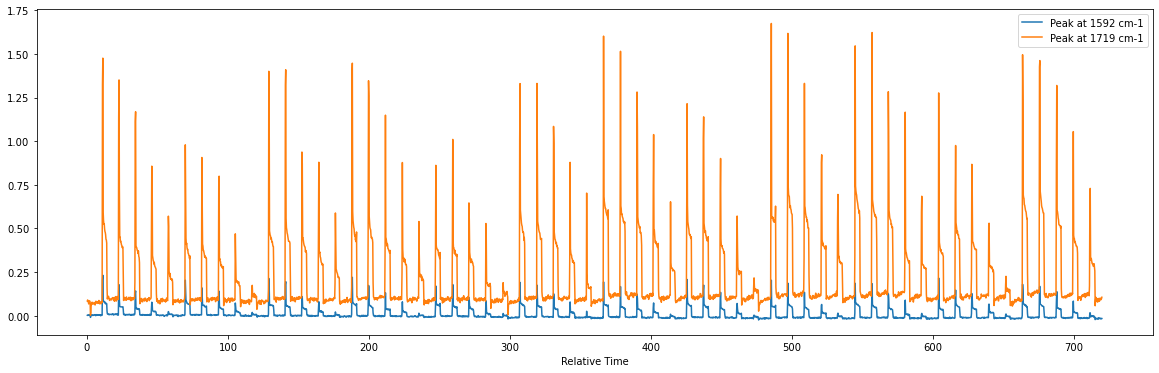

In [58]:
# Instantiate class
Data()

# Load data to dataframe
ir_data = Data.read()

# Visualise the data
Data.plot(ir_data)

Find the Peaks in the Raw Data

In [59]:
# List all the wavelengths observed
peaks = [col for col in ir_data.columns if 'Peak' in col]
print(peaks)

# Choose peak (the first is usually the one we want)
peak_of_interest = peaks[0]

['Peak at 1592 cm-1', 'Peak at 1719 cm-1']


Correct the baseline

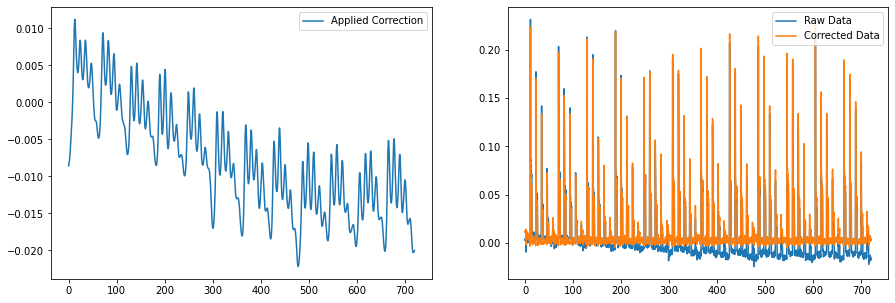

In [60]:
# Perform baseline correction
correction = Data.baseline_correction(ir_data[peak_of_interest], peak_of_interest)
ir_data[peak_of_interest] = ir_data[peak_of_interest] - correction

# Plot it to see
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(ir_data['Relative Time'], correction, label = 'Applied Correction')
ax2.plot(ir_data['Relative Time'], ir_data[peak_of_interest] + correction, label = 'Raw Data')
ax2.plot(ir_data['Relative Time'], ir_data[peak_of_interest], label = 'Corrected Data')
ax1.legend()
ax2.legend()

### Process the IR data (process_ir_data)

Determine several different variables and thresholds

In [7]:
# Instantiate class
peaks = Peaks(ir_data)

prominence, no_reactions, points_per_reaction = peaks.auto_prom(peak_of_interest)
height = peaks.auto_height(peak_of_interest)
residence_time = peaks.auto_area(peak_of_interest, prominence, no_reactions, points_per_reaction)

print('There are', no_reactions, 'reactions with', points_per_reaction, 'points per reaction')
print('Prominence threshold =', np.round(prominence, 4))
print('Height threshold =', np.round(height, 4))
print('Residence time =', np.round(residence_time, 2))

There are 12 reactions with 5 points per reaction
Prominence threshold = 0.0175
Height threshold = 1.0
Residence time = 1.81


Set variables for area integration

In [62]:
time_adjust_before = -1
time_adjust_after = 4

# Check that expreimental area integration captures whole peak (can be slow)
# for var in range(0, no_reactions * points_per_reaction):
#     peaks.exp_area_sp(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after, var)
#     print(var)

Choose peak property, either exp_area, fitted_area, or prominence

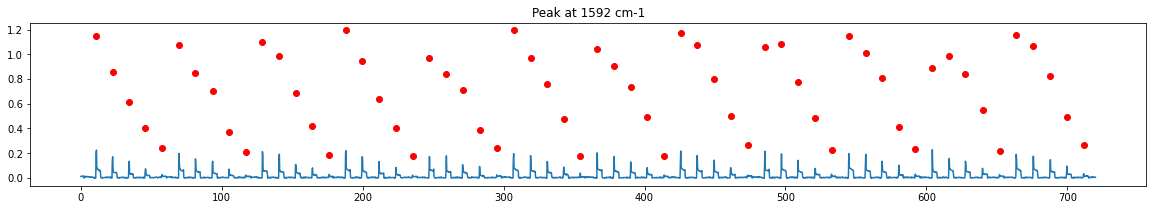

In [9]:
## PROMINENCE: Determine the peak prominences of a single wavelength
#processed_ir_data = peaks.prominence(prominence, peak_of_interest)

## EXP AREA: Determine the experimental areas of a single wavelength
processed_ir_data = peaks.exp_area(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after)

## Visualise which peaks have been picked
peaks.plot(processed_ir_data, peak_of_interest)

### Read experimental conditions and smooth data (load_conditions)

Read experimental conditions from "conditions.xlsx"

In [10]:
Conditions()

experimental_data = Conditions.read(processed_ir_data)

Inputs seem good: IR Datapoints =  60 , Number of conditions =  60


Average the t0 points and perform a linear correction on the rest of the points for each reaction

In [11]:
# Apply t0 correction
experimental_data = Conditions.t0_correction(experimental_data, no_reactions, points_per_reaction)

# Apply linear correction
experimental_data = Conditions.linear_correction_wlr(experimental_data)

In [12]:
# Plot if want to see the difference
#Conditions.plot_corrections(experimental_data, points_per_reaction)

### Create the SPKA profiles (spka)

In [13]:
spka = SPKA(experimental_data)

spka_data = spka.spka('[A]0')

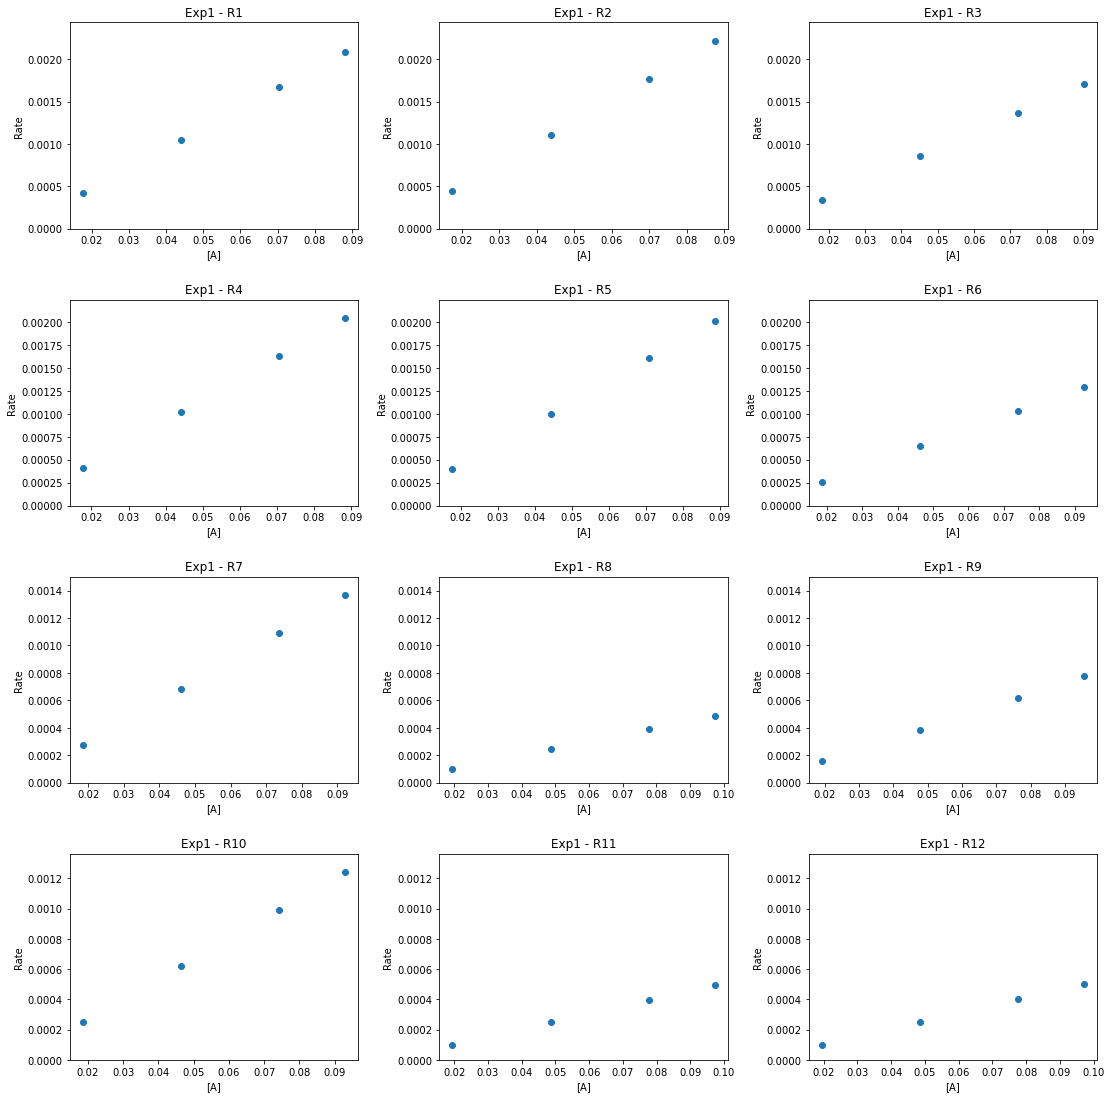

In [63]:
# Plot to see
spka.plot(spka_data, points_per_reaction)

### Perform RPKA (rpka)

In [15]:
rpka = RPKA(spka_data, points_per_reaction)

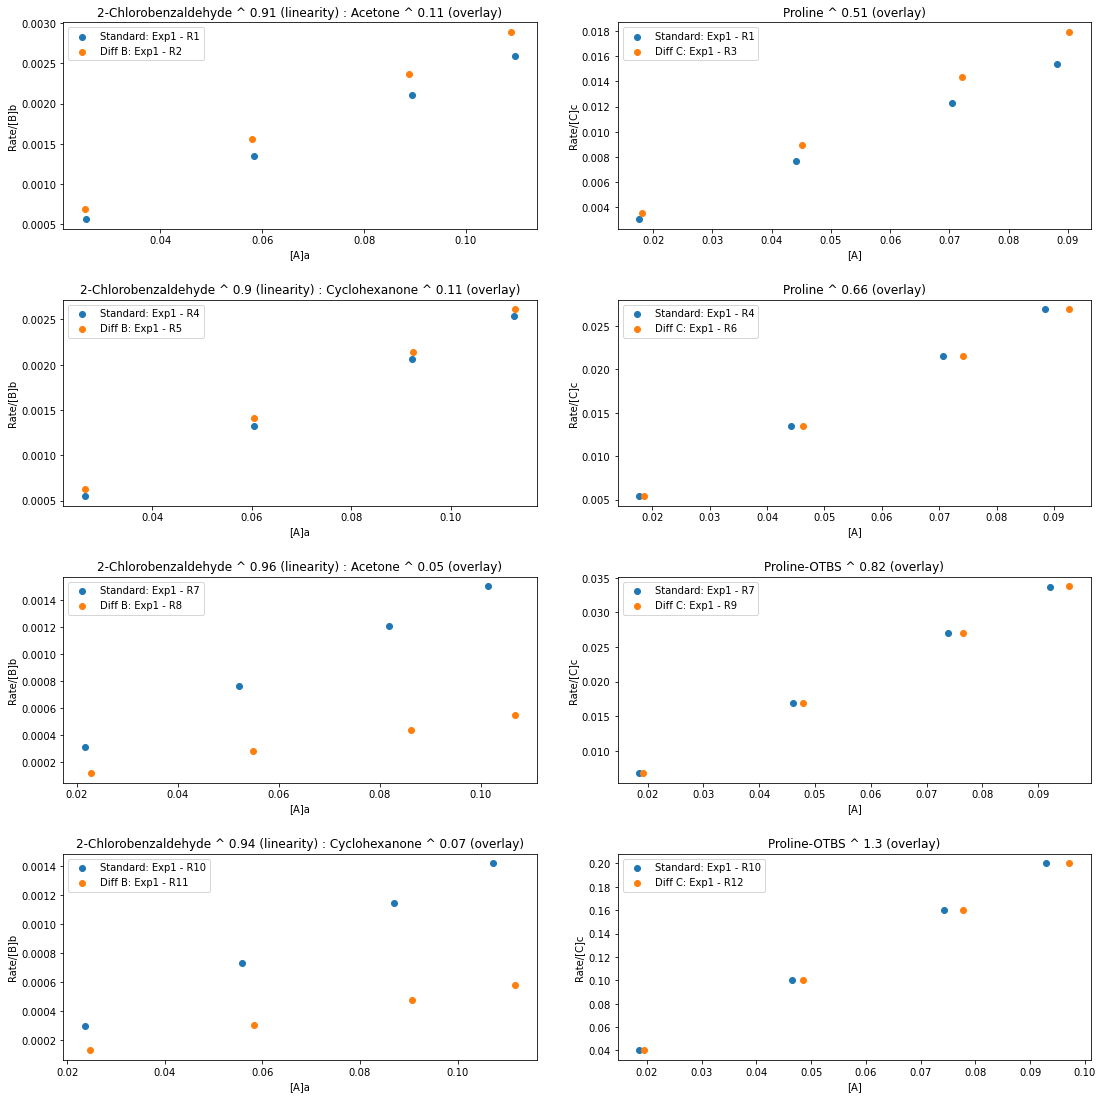

In [37]:
rpka_results = rpka.diff_excess('trust-constr', 0, 2, 2)

# Plot the results to check
rpka.check_results(rpka_results)

Manually change orders: Reaction Number, Order in A (linearity), Order in B (overlay), Order in C (overlay)

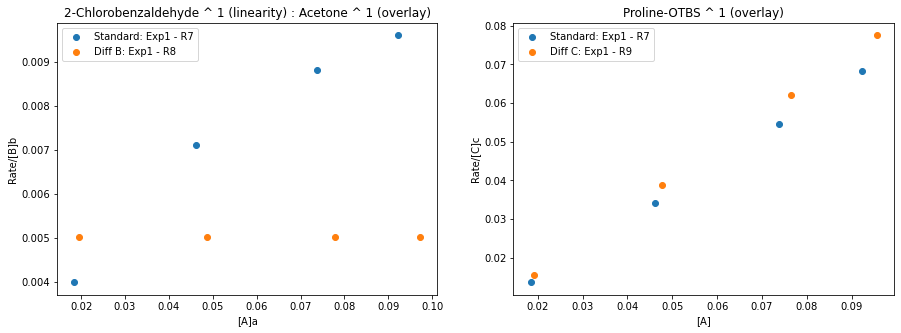

In [55]:
rpka.manual(2, 1, 1, 1)

Export results to excel

In [24]:
# Summarise processing variables
variable_summary_dict = {'Experiment Number':ir_data['Exp No'][0],
                         'Peak' : peak_of_interest,
                         'Number of Reactions' : no_reactions,
                         'Points per Reaction' : points_per_reaction,
                         'Prominence' : prominence,
                         'Height' : height,
                         'Residence Time' : residence_time,
                         'Method Used' : spka_data['Method'][0],
                         'Time adjust before' : time_adjust_before,
                         'Time adjust after' : time_adjust_after
                        }

variable_summary = pd.DataFrame.from_dict(variable_summary_dict, orient='index')

In [25]:
# Set up excelwriter
writer = pd.ExcelWriter(ir_data['Exp No'][0] + ' - ' +   # Adds experiment title - name of txt file
                        peak_of_interest[8:12] + ' - ' + # Adds the peak
                        processed_ir_data['Method'][0] + # Adds the methods used (prominence, area, etc)
                        '.xlsx', engine='xlsxwriter')
workbook=writer.book

# Output data
rpka_results.to_excel(writer, sheet_name='RPKA Data', startrow=0 , startcol=0, index=False)
spka_data.to_excel(writer, sheet_name='SPKA Data', startrow=0 , startcol=0, index=False)
ir_data.to_excel(writer, sheet_name='IR Data', startrow=0 , startcol=0, index=False)
experimental_data.to_excel(writer, sheet_name='Experimental Data', startrow=0 , startcol=0, index=False)
processed_ir_data.to_excel(writer, sheet_name='Processed IR', startrow=0 , startcol=0, index=False)
variable_summary.to_excel(writer, sheet_name='Variable Summary')
#conditions.to_excel(writer, sheet_name='Conditions', startrow=0 , startcol=0, index=False

# Save
writer.save()

# This won't work if the excel file is open